In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns



```

```

## 1. Calling the dataset

In [ ]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['metal',
 'cardboard',
 '.ipynb_checkpoints',
 'plastic',
 'paper',
 'glass',
 'trash']

## 2. Organize images into different folders



In [ ]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

The data now looks like this

/data <br>
&nbsp;&nbsp;&nbsp;&nbsp; /train <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp; /valid <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp;/test <br>

Checkpoint 1: Each image file is just the material name and a number (i.e. cardboard1.jpg)


In [ ]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

The data was randomized and ready for training


In [ ]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

The batch size bs is how many images you'll train at a time. Choose a smaller batch size if your computer has less memory. 

You can use get_transforms() function to augment your data. I'll compare the results from flipping images horizontally and vertically.

In [ ]:
data

ImageDataBunch;

Train: LabelList (1229 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
metal,metal,metal,metal,metal
Path: /content/data;

Valid: LabelList (613 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
metal,metal,metal,metal,metal
Path: /content/data;

Test: LabelList (618 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [ ]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Here's an example of what the data looks like:

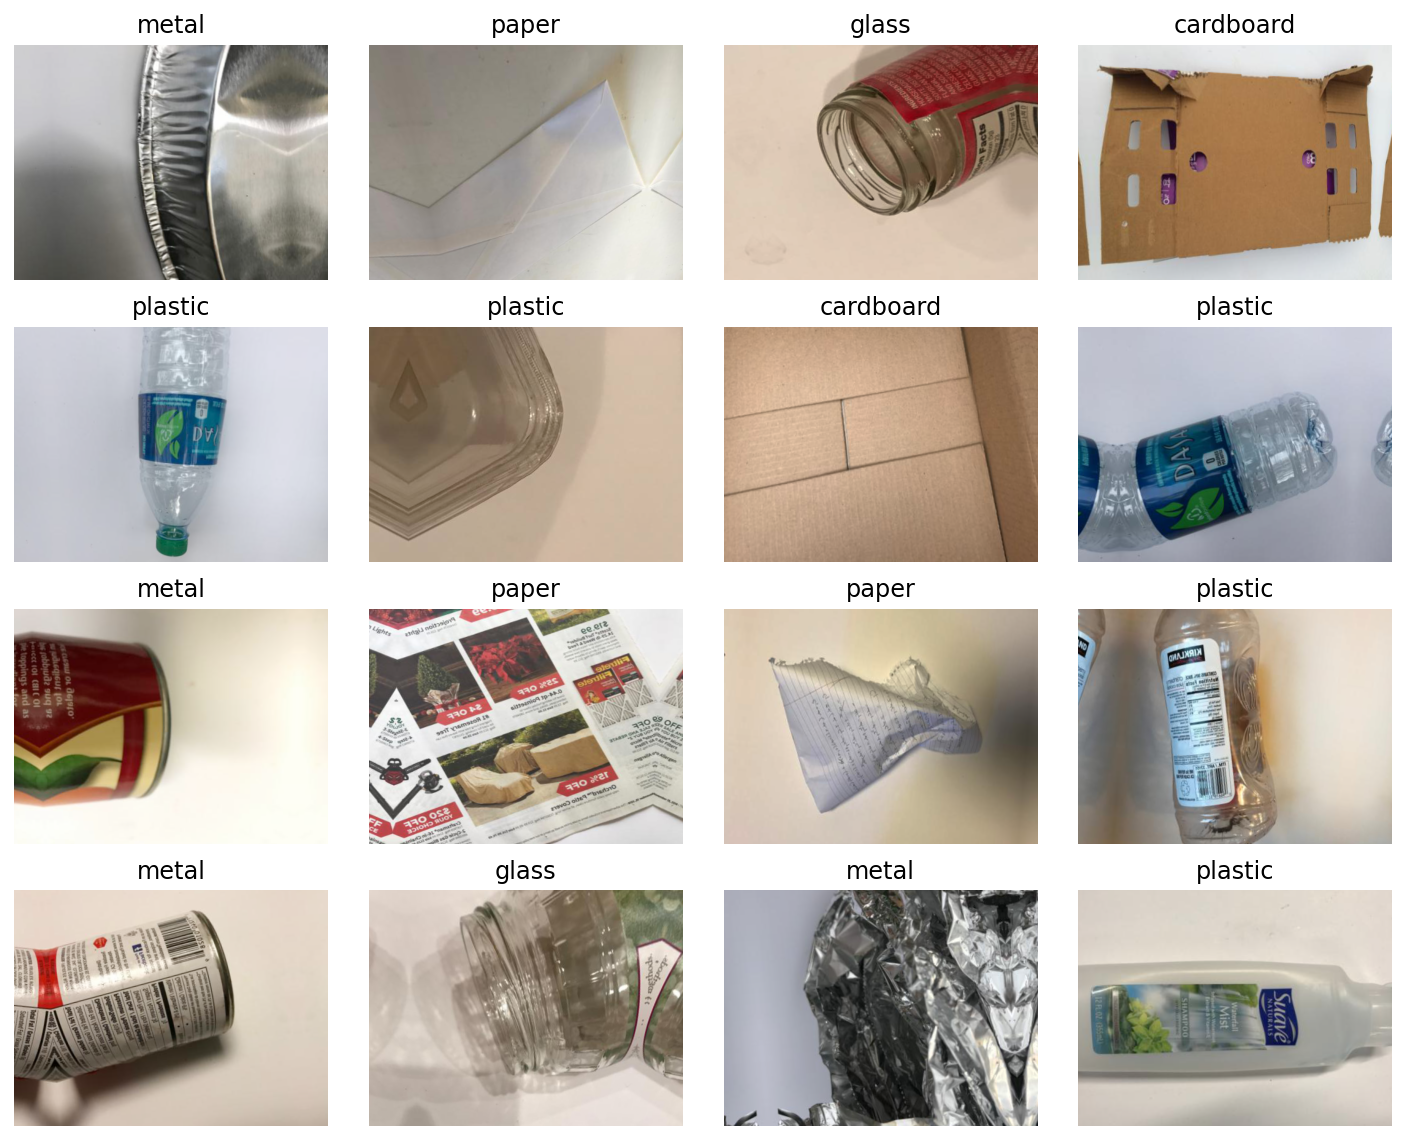

In [ ]:
data.show_batch(rows=4,figsize=(10,8))

## 3. Model training

In [ ]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Training using Resnet32

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

The learning rate finder suggests a learning rate of 5.13e-03. With this, we can train the model.

### Training

In [ ]:
learn.fit_one_cycle(1,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time
0,1.440077,0.757799,0.200653,29:13



A look at which images were most incorrectly classified is made at this stage

### VIsualizing most incorrect images

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

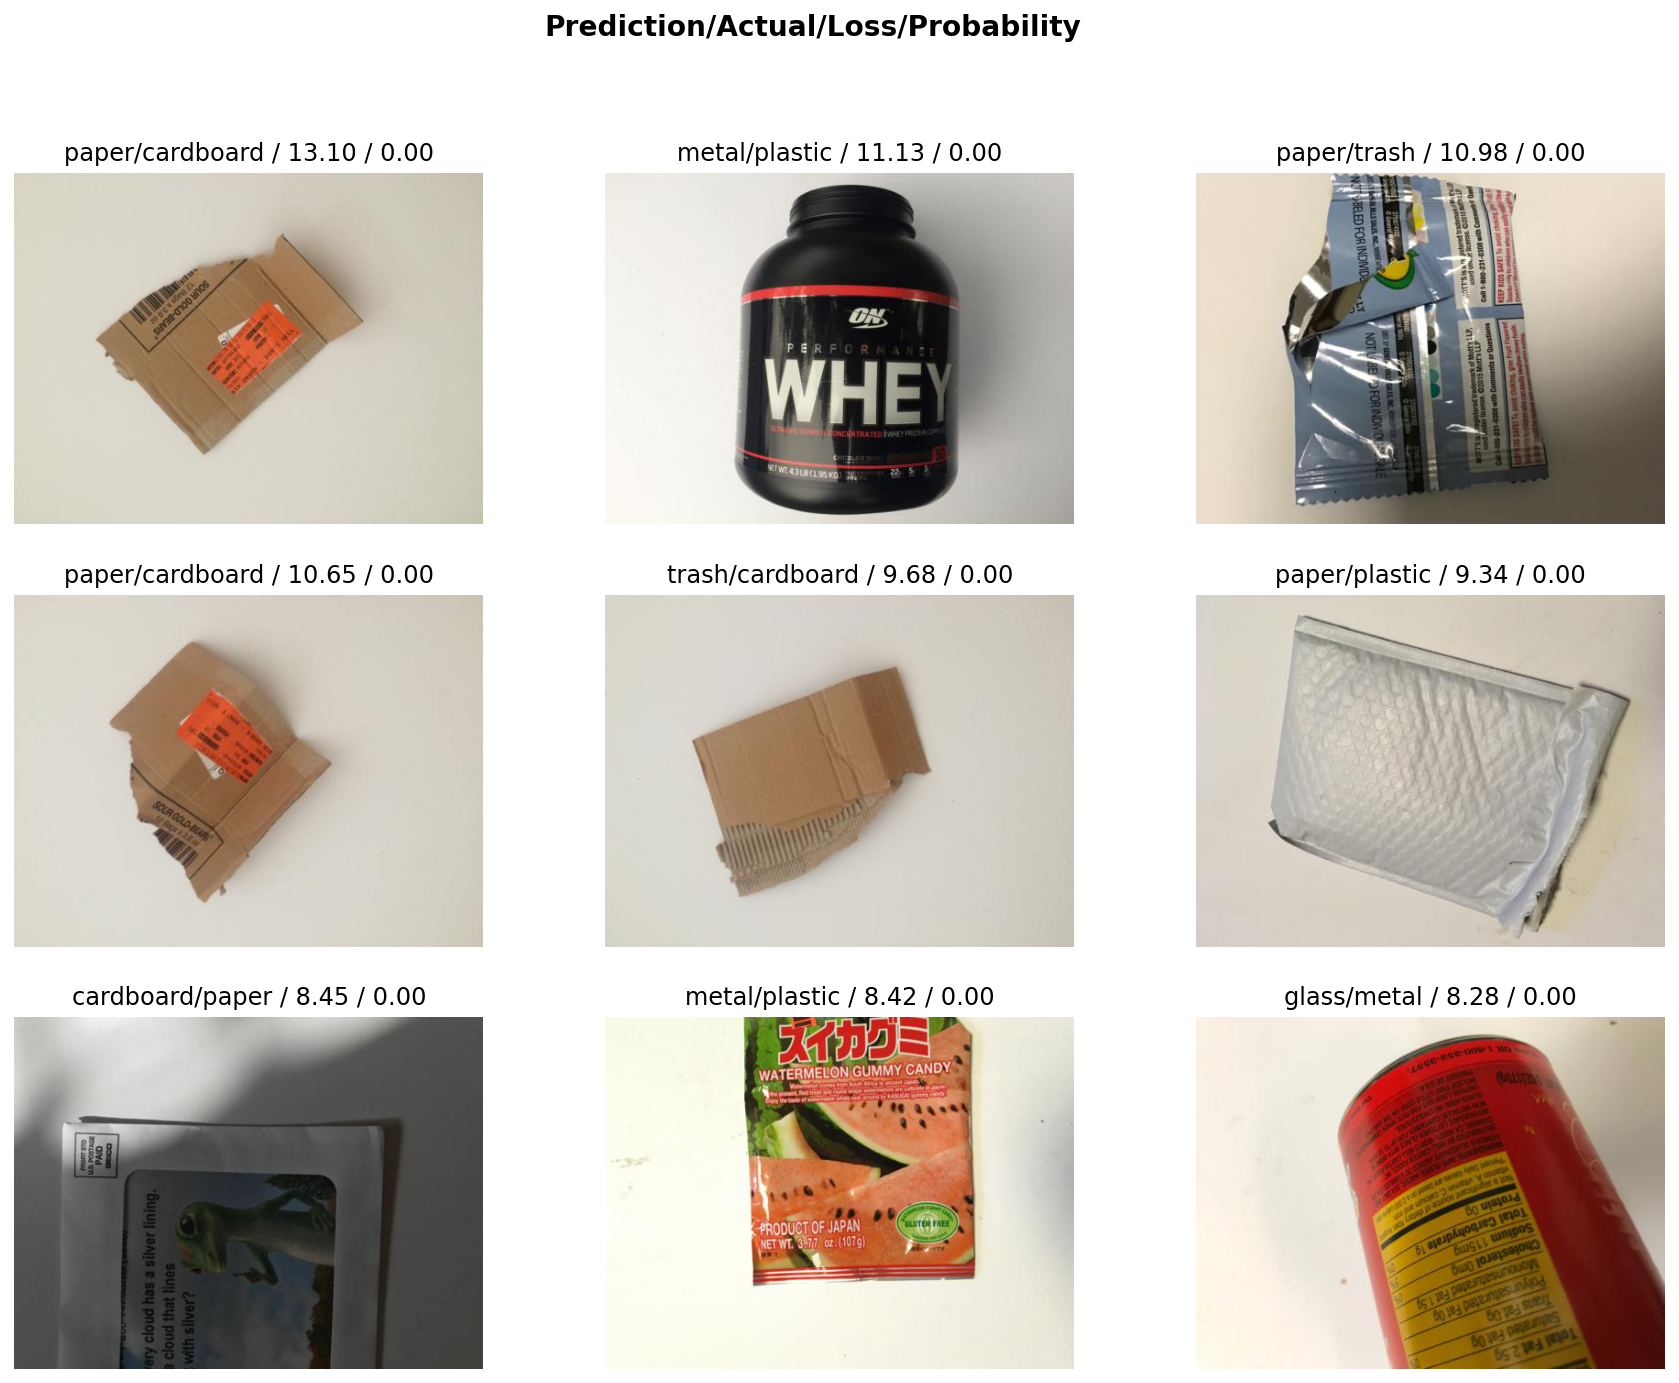

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

The images were so similar to other classes and hence mispredicted. This will make us detect which catafory is classified wrong in the model


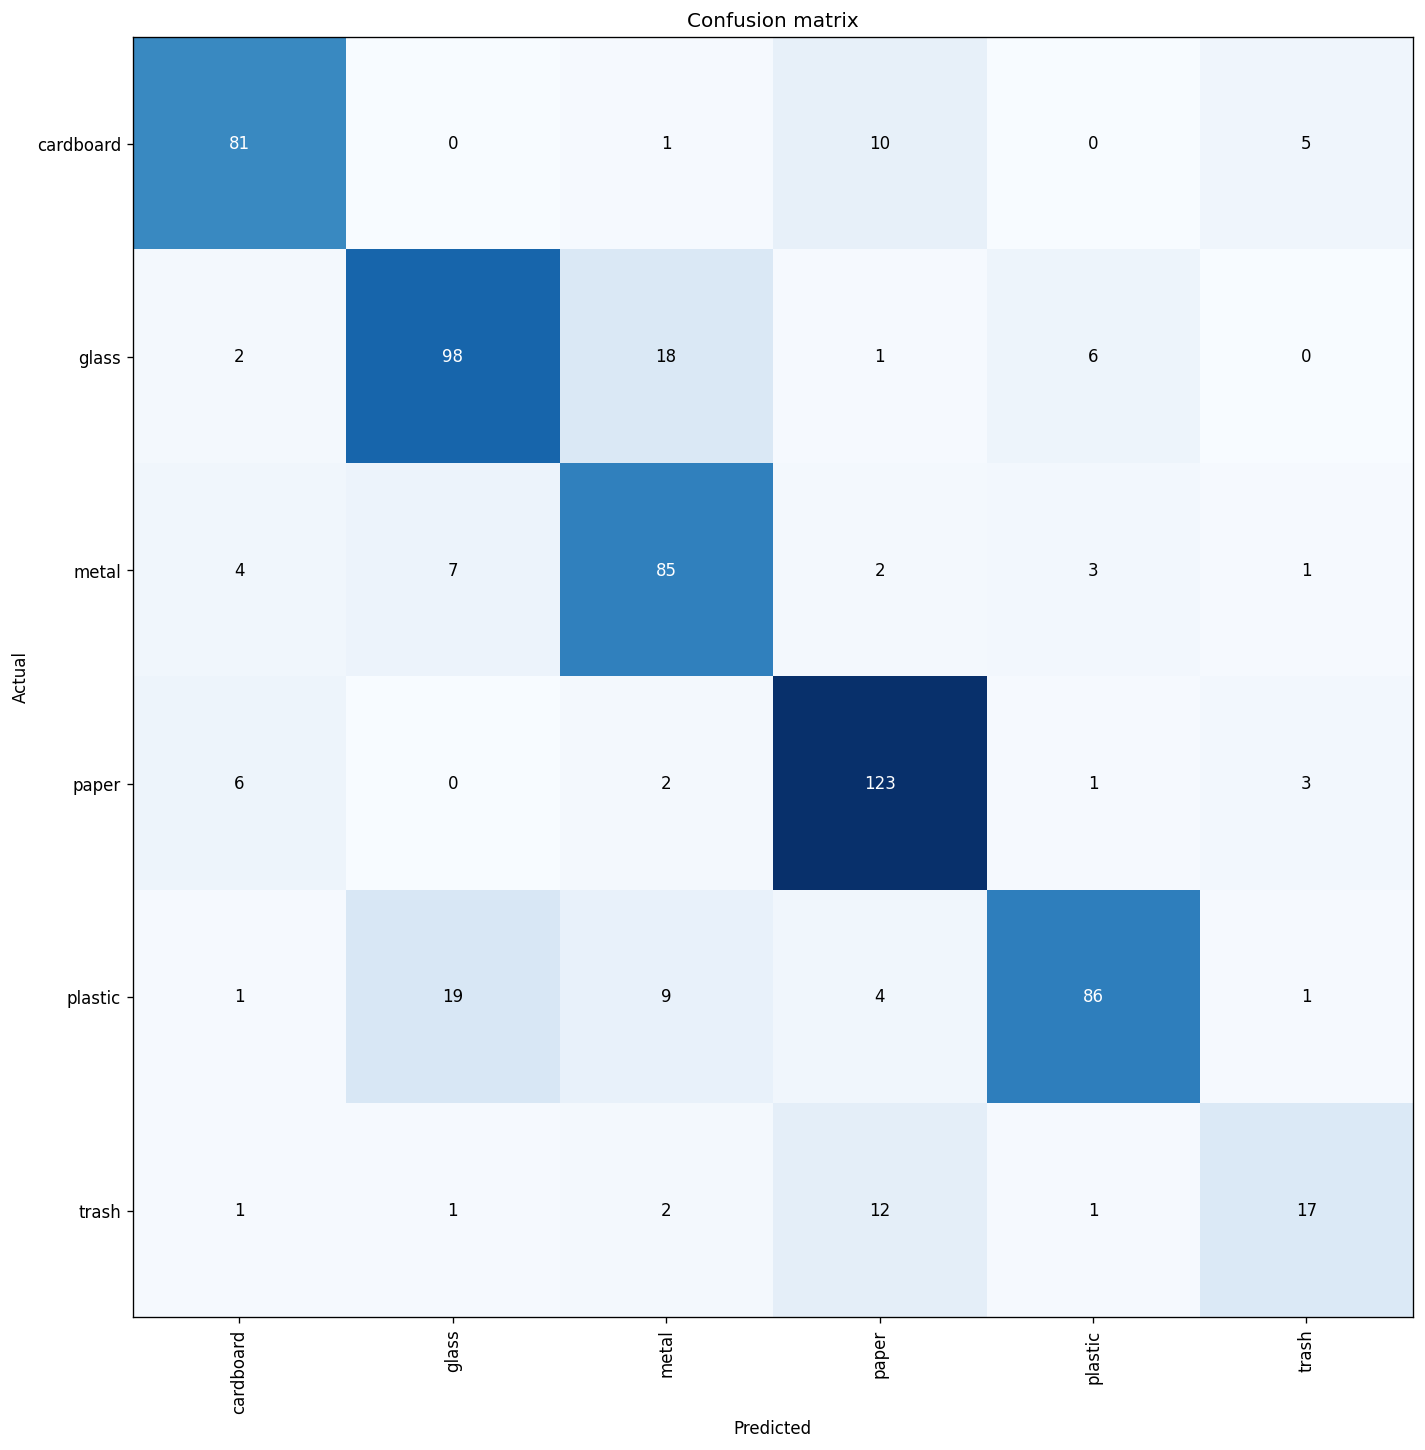

In [ ]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

This model often confused plastic for glass and confused metal for glass. The list of most confused images is below.

In [ ]:
interp.most_confused(min_val=2)

[('plastic', 'glass', 19),
 ('glass', 'metal', 18),
 ('trash', 'paper', 12),
 ('cardboard', 'paper', 10),
 ('plastic', 'metal', 9),
 ('metal', 'glass', 7),
 ('glass', 'plastic', 6),
 ('paper', 'cardboard', 6),
 ('cardboard', 'trash', 5),
 ('metal', 'cardboard', 4),
 ('plastic', 'paper', 4),
 ('metal', 'plastic', 3),
 ('paper', 'trash', 3),
 ('glass', 'cardboard', 2),
 ('metal', 'paper', 2),
 ('paper', 'metal', 2),
 ('trash', 'metal', 2)]

## 4. Make new predictions on test data

To make predictions of the test data, we use the function "get_preds" where it make a predication for all the data in the "Test images"

In [ ]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Now, converting the output into classes in the array of yhat then running the code to get the predection for every image in the "Test Images"

In [ ]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [ ]:
yhat

['paper',
 'paper',
 'paper',
 'metal',
 'metal',
 'glass',
 'plastic',
 'glass',
 'glass',
 'metal',
 'glass',
 'paper',
 'glass',
 'plastic',
 'paper',
 'glass',
 'paper',
 'plastic',
 'plastic',
 'metal',
 'cardboard',
 'paper',
 'plastic',
 'glass',
 'metal',
 'cardboard',
 'glass',
 'cardboard',
 'paper',
 'metal',
 'paper',
 'plastic',
 'paper',
 'glass',
 'plastic',
 'metal',
 'paper',
 'metal',
 'paper',
 'plastic',
 'plastic',
 'cardboard',
 'plastic',
 'metal',
 'glass',
 'paper',
 'paper',
 'metal',
 'paper',
 'glass',
 'metal',
 'metal',
 'paper',
 'glass',
 'metal',
 'cardboard',
 'plastic',
 'metal',
 'metal',
 'plastic',
 'paper',
 'paper',
 'paper',
 'cardboard',
 'cardboard',
 'cardboard',
 'plastic',
 'glass',
 'plastic',
 'cardboard',
 'metal',
 'plastic',
 'paper',
 'glass',
 'paper',
 'plastic',
 'cardboard',
 'glass',
 'cardboard',
 'plastic',
 'glass',
 'metal',
 'paper',
 'metal',
 'cardboard',
 'metal',
 'cardboard',
 'cardboard',
 'paper',
 'plastic',
 'metal'

These are the predicted labels of all the images! Now we will check if the first Image is actually "Paper"

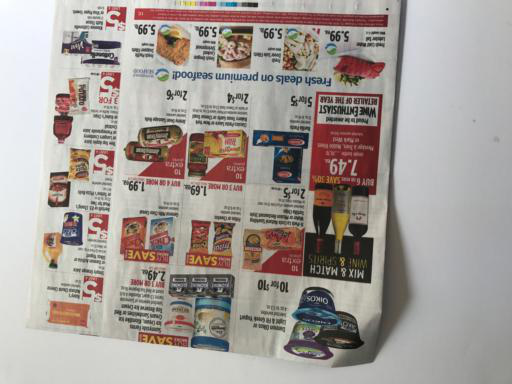

In [ ]:
learn.data.test_ds[1][0]

 The first predection is paper and it is actually right!

Next, I'll get the actual labels from the test dataset.

In [ ]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

A quick check.

In [ ]:
## predicted values
print(yhat[5:10])
## actual values
print(y[5:10])

['glass', 'plastic', 'glass', 'glass', 'metal']
['glass', 'plastic', 'glass', 'glass', 'metal']


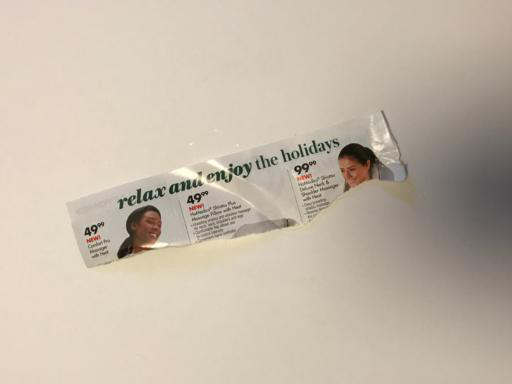

In [ ]:
learn.data.test_ds[0][0]

If we take a random predication from the fifth image to the tenth, we will find that the model could identify them all. However, the model still mistakes a class with another, but we will equate the whole accurcy to find out.

to evaluate the model's reliability, we use a confusion matrix.

### Test confusion matrix

In [ ]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 84   0   4  10   0   0]
 [  2  87  24   2  11   0]
 [  1  16  78   4   2   2]
 [  3   1   2 128   1   0]
 [  0  17  10   0  89   5]
 [  3   4   6  10   3   9]]


Making the shape of the confusion matrix



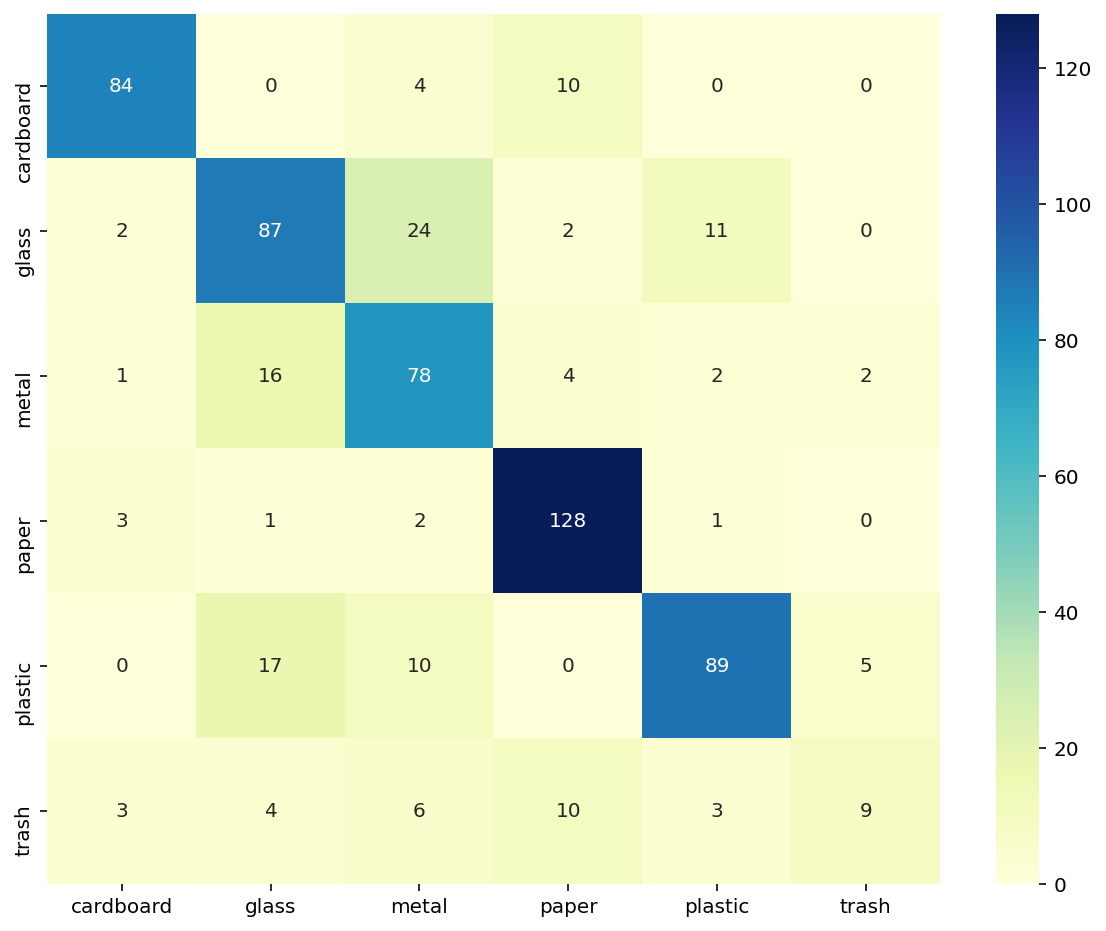

In [ ]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

Again, the model seems to have confused metal for glass and plastic for glass. With more time, further investigation could help reduce these mistakes, and increasing "Reliability"


##Finally, the Accuracy

In [ ]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [ ]:
accuracy = correct/sum(sum(cm))
accuracy

0.7686084142394822